## Measuring Equity Risk

In this notebook we'll explore two statistical methods for calculating Equity Risk:

+ Variance: fluctuation of stock return from its mean
+ VaR: the maximum an investor could loose (within a confidence interval)

For the purposes of this notebook, we'll explore the above looking at the risk of Apple (ticker = AAPL).

In [139]:
# Import all the required packages
# The pandas_datareader library contains functions which allow us to call data from various internet sources
import pandas as pd
import quandl
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import linear_model
plt.style.use('fivethirtyeight')
from statsmodels.formula.api import ols

# Use Python's "magic" commands since we want to see the graphs within this notebook
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/slemasne/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [140]:
directory = os.getcwd() + "/data/"

In [141]:
class loadData():
    
    def __init__(self, ticker):
        self.ticker = ticker
    
    def source_data(self, source = "api"):
        
        if source == "api":
            quandl.ApiConfig.api_key = "U4JsbXnxqewAQH5ACxAa" # Password has been  changed before publishing this notebook
            ticker_data = quandl.get_table('WIKI/PRICES', ticker = self.ticker)
            ticker_data = ticker_data[['date','adj_close']][-1000:].set_index("date")
            ticker_data["{}".format(self.ticker) + "_returns"] = ticker_data["adj_close"].pct_change(1)
            
        if source == "csv":
            path = directory + "{}.csv".format(self.ticker)
            ticker_data = pd.read_csv(path, parse_dates=True, index_col='date')
            ticker_data = ticker_data[["adj_close"]]
            ticker_data["{}".format(self.ticker) + "_returns"] = ticker_data["adj_close"].pct_change(1)
        
        return ticker_data.dropna(axis=0)

In [142]:
aapl = loadData("AAPL").source_data("api")
snp500 = loadData("SNP500").source_data("csv")

data = aapl.join(snp500, on = "date", lsuffix = "aapl")
data = data[["SNP500_returns","AAPL_returns"]]
data = data.dropna()

data.head(2)

,SNP500_returns,AAPL_returns
date,,
2014-04-08,0.007189,-0.000057
2014-04-09,-0.001534,0.013144


### Stock Variance

First, lets check the summary statistics for both AAPL and the S&P Index. We can also plot the returns as a histogram to get an idea of dispersion of returns.

In [143]:
# Here we can see AAPL has a mean return of around 0.11% with standard deviation 1.4%
# The minimum return was -6.5% and the max 8.2%

aapl_summary = data["AAPL_returns"].describe()
aapl_summary

count    855.000000
mean       0.001122
std        0.014059
min       -0.065707
25%       -0.005621
50%        0.000893
75%        0.008646
max        0.081982
Name: AAPL_returns, dtype: float64

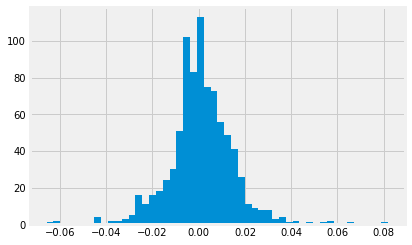

In [144]:
# Lets now plot the distribution of returns using our favourite "FiveThirtyEight" styled histogram

data["AAPL_returns"].hist(bins=50, figsize=(6,4))

In [145]:
# There are some outliers
# Lets check on what date AAPL had a min and max return

max_date = data.loc[data['AAPL_returns'].idxmax()].name.date()
min_date = data.loc[data['AAPL_returns'].idxmin()].name.date()

print ("The max value for aapl was recorded on {} while the min value was recorded on {}".format(max_date, min_date))

The max value for aapl was recorded on 2014-04-24 while the min value was recorded on 2016-01-27


In [146]:
# Now, lets do the same for the S&P returns, and plot them side by side

snp_summary = data["SNP500_returns"].describe()
snp_summary 

count    855.000000
mean       0.000404
std        0.007670
min       -0.039414
25%       -0.002640
50%        0.000419
75%        0.004441
max        0.039034
Name: SNP500_returns, dtype: float64

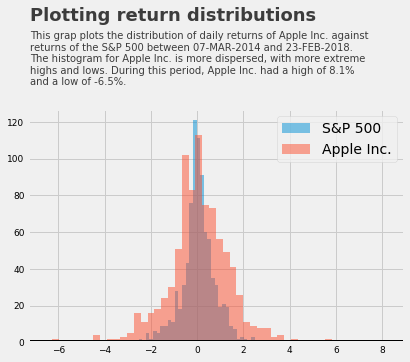

In [147]:
style.use('fivethirtyeight')

x = data["SNP500_returns"] * 100
y = data["AAPL_returns"] * 100

plt.hist(x, alpha = 0.5, bins=50, label='S&P 500')
plt.hist(y,alpha = 0.5, bins = 50, label='Apple Inc.')
plt.legend(loc='upper right')
plt.tick_params(axis = 'both', which = 'major', labelsize = 9)
plt.axhline(y = 0, color = 'black', linewidth = 5, alpha = 1)
#plt.xlabel(s = "% return", fontsize = "small")

plt.text(-7.2, 140, s = """This grap plots the distribution of daily returns of Apple Inc. against 
returns of the S&P 500 between 07-MAR-2014 and 23-FEB-2018. 
The histogram for Apple Inc. is more dispersed, with more extreme 
highs and lows. During this period, Apple Inc. had a high of 8.1%
and a low of -6.5%.""", fontsize = 10, alpha = .75)

plt.text(-7.2, 175, s = """Plotting return distributions""", weight = "bold", fontsize = 18, alpha = .75)
plt.show()

### Value at Risk (VaR)

In [148]:
from scipy.stats import norm

def var_cov_var(P, c, m, sigma):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns m
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = norm.ppf(1-c, m, sigma)
    return P - P*(alpha + 1)

P = 1000000   # 1,000,000 USD
c = 0.99  # 99% confidence interval

aapl_mean = data["AAPL_returns"].mean()
aapl_sigma = data["AAPL_returns"].std()

snp_mean = data["SNP500_returns"].mean()
snp_sigma = data["SNP500_returns"].std()

var_aapl = var_cov_var(P, c, aapl_mean, aapl_sigma)
var_snp = var_cov_var(P, c, snp_mean, snp_sigma)

print ("The one day VaR for Apple on a $1 million portfolio is ${:,.2f}".format(round(var_aapl,2)))
print ("The one day VaR for the S&P 500 on a $1 million portfolio is ${:,.2f}".format(round(var_snp,2)))

The one day VaR for Apple on a $1 million portfolio is $31,582.78
The one day VaR for the S&P 500 on a $1 million portfolio is $17,439.45
